In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
from skimage import io
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
DEV_ROOT_DIR = os.path.abspath("../../..")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import cv2
import skimage

import nucleus

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

COULD NOT SET MEMORY GROWTH
adding root dir /research/lab_gsf/bhaladik/ExTrAct-AML_methods/tf_2_4_1_keras_2_4_3_code to path


### Visualizing model segmentations for our neuroblastoma MRCNN model

This notebook demonstrates segmentations with our segmentation model on SK-N-SH cell-line images.  
You need to have downloaded the model and at least installed the minimal setup as described in the setup README at `setup/README.md` to make this notebook work.

In [2]:
# Initialize model, use CPU for inference, because we want to be able to run on machines without GPUs
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
config = nucleus.NucleusInferenceConfig()
config.USE_MINI_MASK = False
config.display()
# Create model in inference mode
TEST_MODE = "inference"
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)
    

data_folder = "../../example_data/"
weights_path = os.path.join(data_folder, "mask_rcnn_nucleus_0090.h5")

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [4]:
### we import the functionality from our custom segmentation module for cellprofiler here
import segmentation_functions

In [5]:
##### The functionality below is for segmenting images and visualizing outlines together with confidence scores

def make_image_meta(orig_image, config, im_id=1.):
    image, window, scale, padding, crop = utils.resize_image(orig_image, min_dim=config.IMAGE_MIN_DIM,
                                                            min_scale=config.IMAGE_MIN_SCALE,
                                                            max_dim=config.IMAGE_MAX_DIM,
                                                            mode=config.IMAGE_RESIZE_MODE)
    active_class_ids = np.zeros([config.NUM_CLASSES], dtype=np.int32)
    active_class_ids[-1] = 1
    image_meta = modellib.compose_image_meta(im_id, orig_image.shape, image.shape, window, scale, active_class_ids)
    return image, image_meta


def segment_and_visualize(input_image, config, visualize_segmentation=True, im_id=1., quarter=False):
    if not quarter:
        image, image_meta = make_image_meta(input_image, config)
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=False)
        r = results[0]
        if visualize_segmentation:
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                     ["BG", "nucleus"], r['scores'], ax=get_ax(1),
                                     show_bbox=False, show_mask=False,
                                     title="Predictions")
        out_im = masks_to_image(r['masks'], image.shape[:2])
        out_masks = r['masks']
    else:
        images_per_quarter = []
        regions_per_quarter = []
        quarters = segmentation_functions.quarter_image(input_image)
        for quarter in quarters:
            image, image_meta = make_image_meta(quarter, config)
            results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=False)
            r = results[0]
            if visualize_segmentation:
                visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                         ["BG", "nucleus"], r['scores'], ax=get_ax(1),
                                         show_bbox=False, show_mask=False,
                                         title="Predictions")
            out_im = masks_to_image(r['masks'], image.shape[:2])
            images_per_quarter.append(out_im)
            regions_per_quarter.append(r)
        out_im = images_per_quarter
        out_masks = regions_per_quarter
    return out_im, out_masks

def masks_to_image(mask_array, image_shape):
    out_im = np.zeros(image_shape, dtype=np.int16)
    print('Creating mask segmentation image from mask of shape {}'.format(mask_array.shape))
    print('Lets sort by size')
    sizes = np.sum(mask_array, axis=(0,1))
    print('Using {} values'.format(sizes.shape))
    indices = np.argsort(sizes)
    for i in indices:
        mask = mask_array[:, :, i]
        # to have separated objects, take the remaining background pixels and add the object to them
        out_im += (~((out_im > 0) & (mask > 0))).astype(np.int16) * (mask.astype(np.bool) * (i+1)).astype(np.int16)
        #out_im += (mask.astype(np.bool) * (i+1))
    print('Labeled image has {} unique entries'.format(len(list(np.unique(out_im))) - 1))
    return out_im

def resize(segmentation_mask, output_shape, binarize=False):
    print('Unique values in input mask are')
    print(np.unique(segmentation_mask))
    #resized = skimage.transform.resize(segmentation_mask, output_shape, preserve_range=True, mode='constant')
    resized = cv2.resize(segmentation_mask, output_shape, interpolation=cv2.INTER_LINEAR)
    print('Unique values in output mask are')
    print(np.unique(resized.astype(np.uint16)))
    if binarize:
        resized = resized.astype(np.bool)
    else:
        resized = resized.astype(np.int16)
    return resized

def masks_to_resized(mask_array, target_shape):
    out_im = np.zeros(target_shape, dtype=np.int16)
    print('Creating mask segmentation image from mask of shape {}'.format(mask_array.shape))
    print('Lets sort by size')
    sizes = np.sum(mask_array, axis=(0,1))
    print('Using {} values'.format(sizes.shape))
    indices = np.argsort(sizes)
    for i in indices:
        mask = mask_array[:, :, i]
        res = skimage.transform.resize((mask > 0), target_shape)
        # to have separated objects, take the remaining background pixels and add the object to them
        out_im += (~((out_im > 0) & (res > 0))).astype(np.int16) * (res * (i+1)).astype(np.int16)
        #out_im += (mask.astype(np.bool) * (i+1))
    print('Labeled image has {} unique entries'.format(len(list(np.unique(out_im))) - 1))
    return out_im


def show_segmentation(labeled, try_resize=True):
    if try_resize:
        if len(labeled.shape) < 3:
            labeled = resize(labeled, (512,512))
        else:
            print('Applying mask resize')
            labeled = masks_to_resized(labeled, (512,512))
    fig, ax = plt.subplots(figsize=(14,14))
    ax.imshow(labeled)
    fig.show()

In [6]:
## code below packs all of this into one function   
def read_image_show_segmentation_with_score(in_path, config, quarter=False):
    image = io.imread(in_path)
    image = segmentation_functions.preprocess_image(image)
    seg, masks = segment_and_visualize(image, config, quarter=quarter)
    return seg, masks

In [7]:
## load images
images_folder = os.path.join(data_folder, 'sk_n_sh_example_images')
## get DAPI channel images, which are the first channel
im_paths_nb = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f)) and ('ch1' in f)]

../../example_data/sk_n_sh_example_images\r05c17f04p01-ch1sk1fk1fl1.tiff


c:\Users\ben.haladik\AppData\Local\anaconda3\envs\minimal_segmentation\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Creating mask segmentation image from mask of shape (1152, 1152, 215)
Lets sort by size
Using (215,) values
Labeled image has 215 unique entries
Creating mask segmentation image from mask of shape (1152, 1152, 259)
Lets sort by size
Using (259,) values
Labeled image has 258 unique entries
Creating mask segmentation image from mask of shape (1152, 1152, 264)
Lets sort by size
Using (264,) values
Labeled image has 264 unique entries
Creating mask segmentation image from mask of shape (1152, 1152, 396)
Lets sort by size
Using (396,) values
Labeled image has 396 unique entries


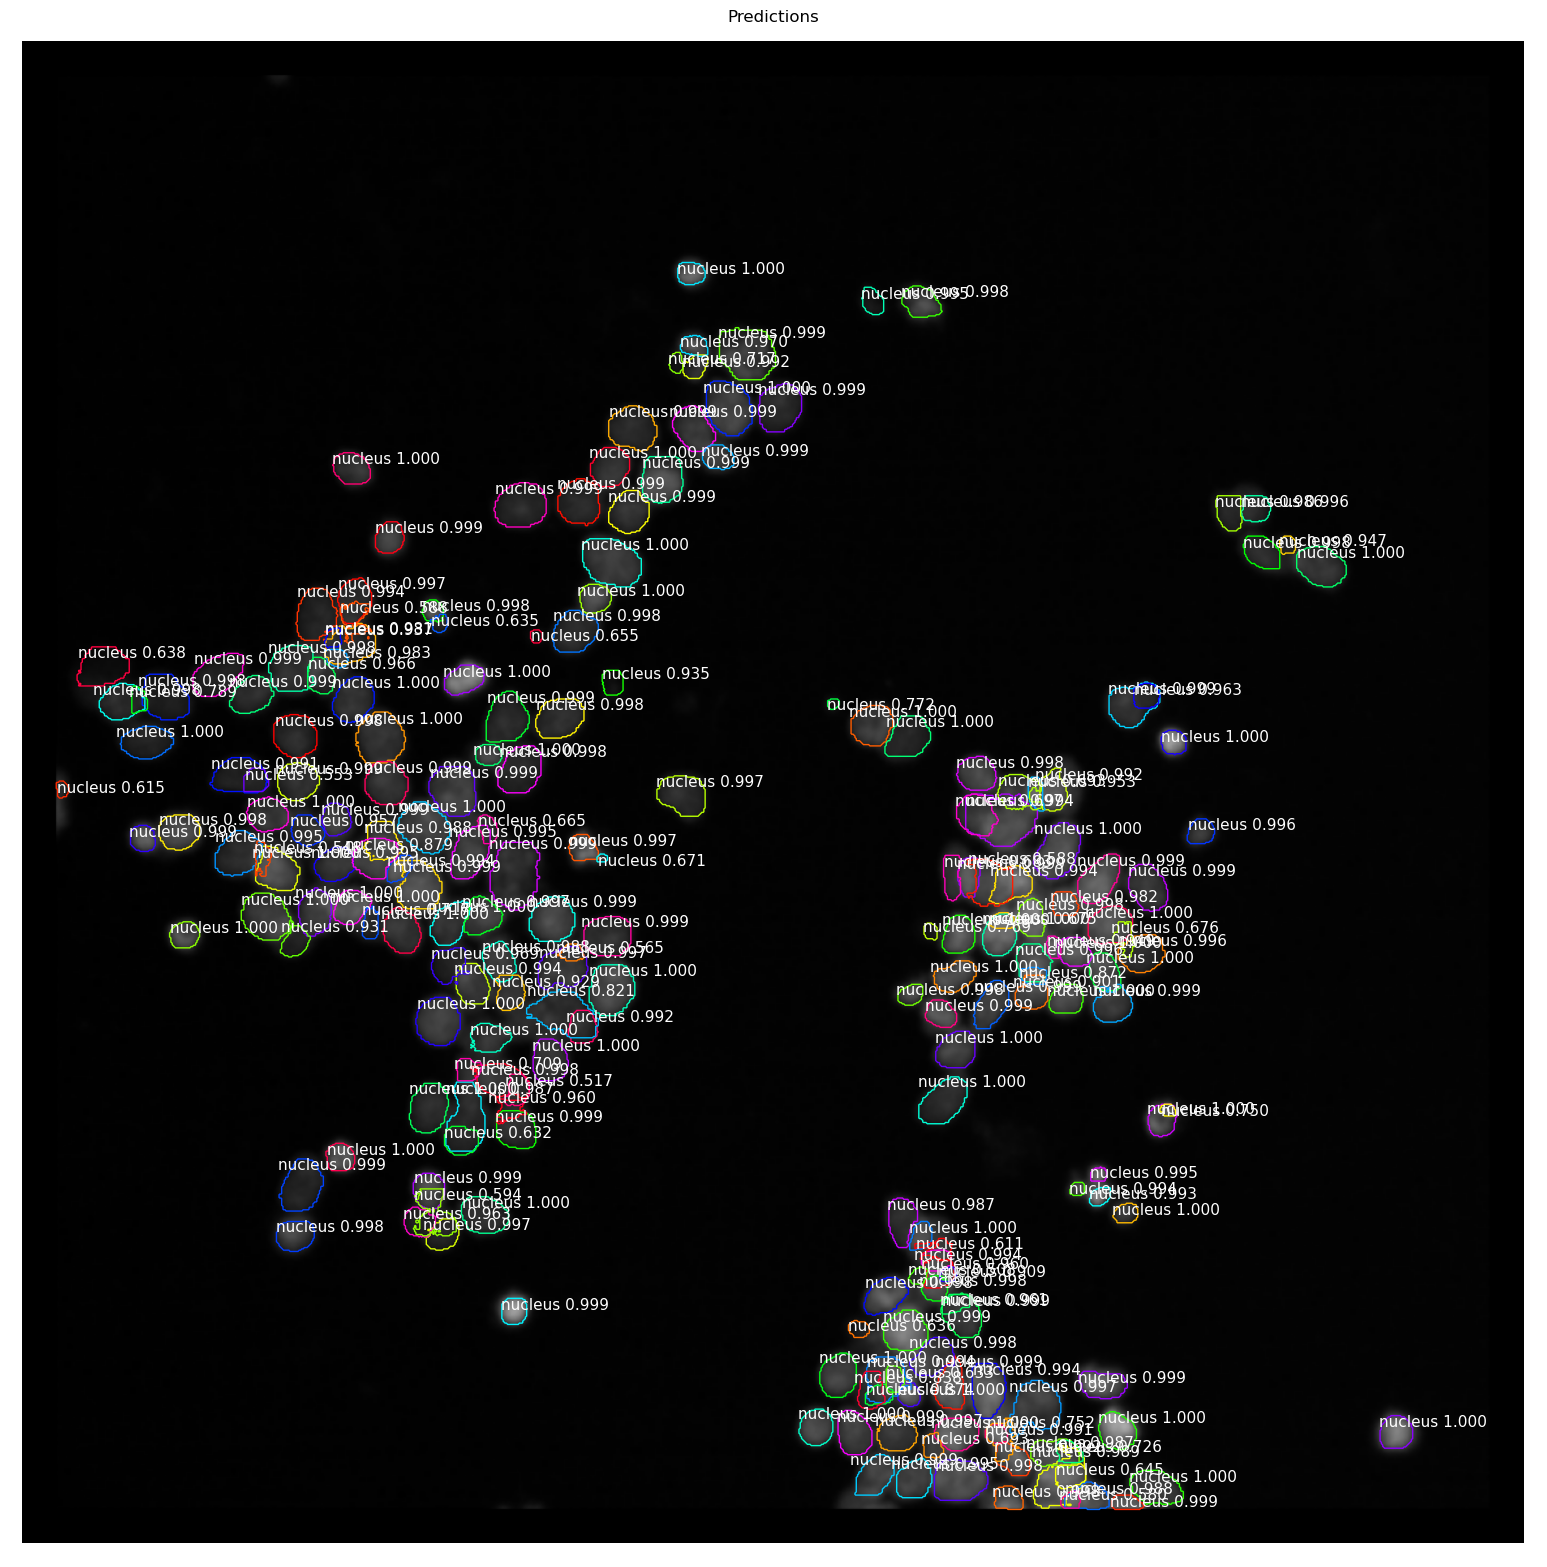

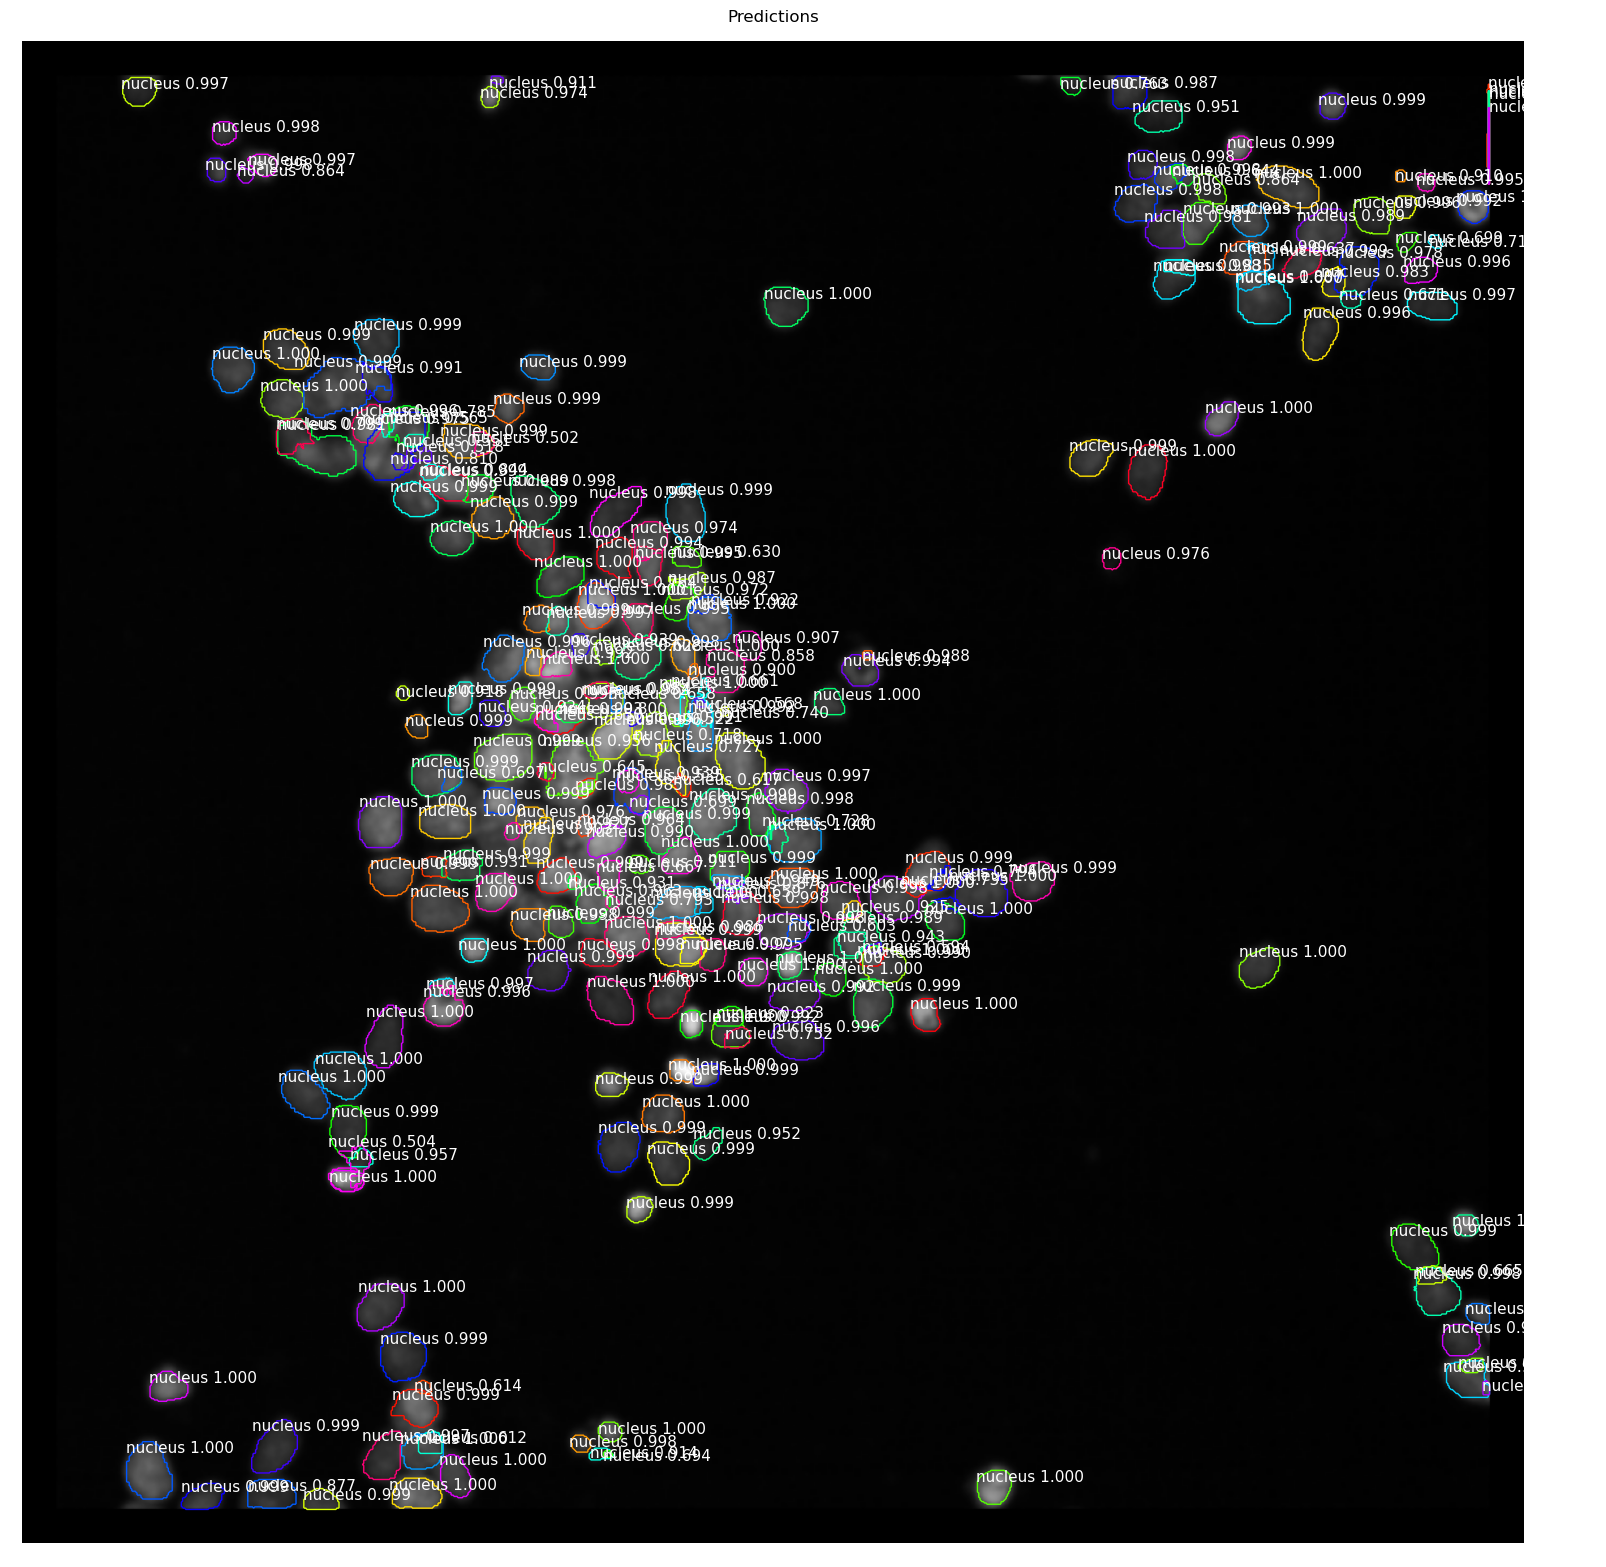

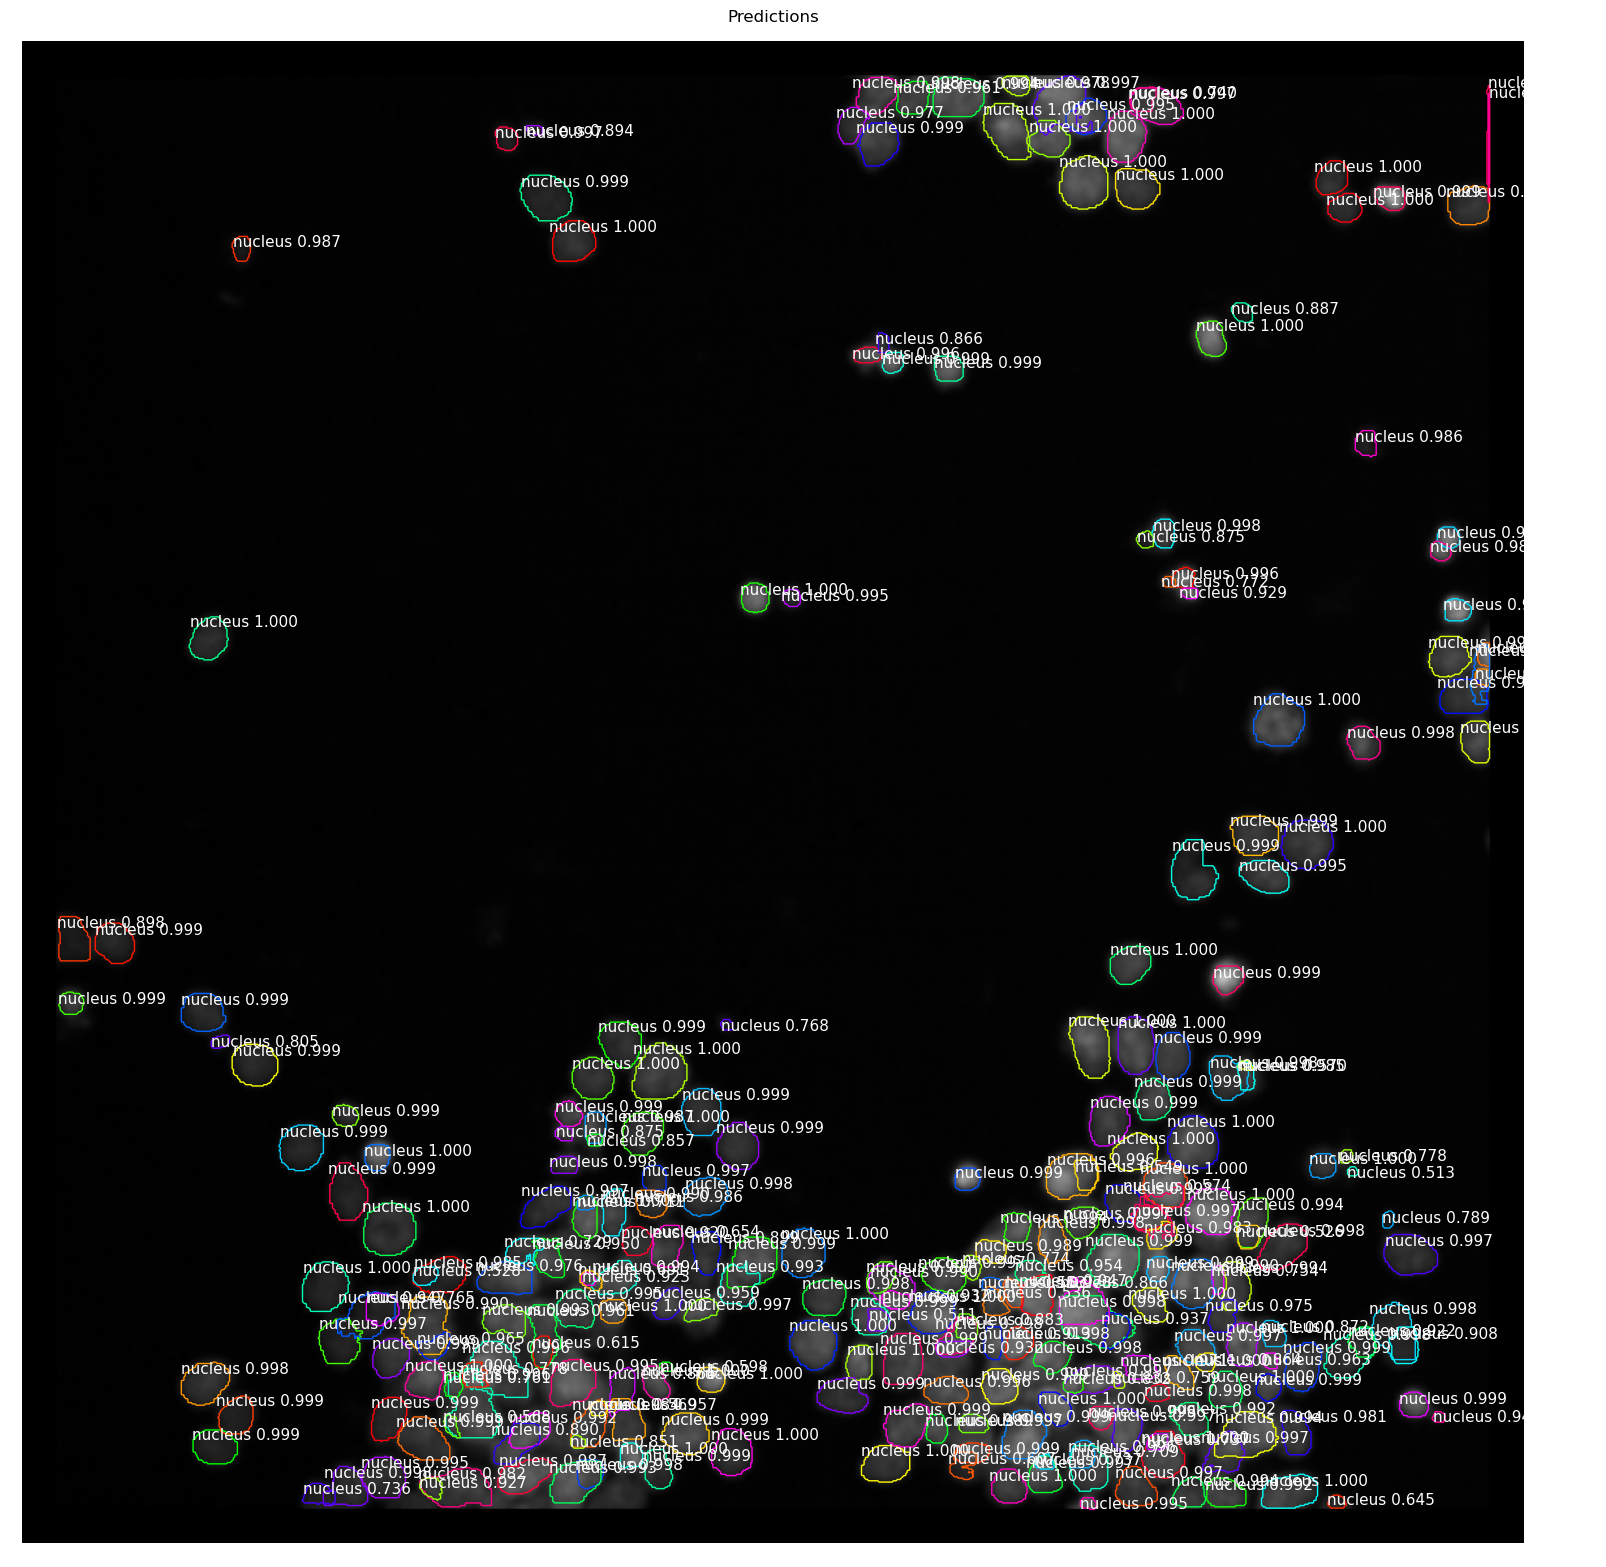

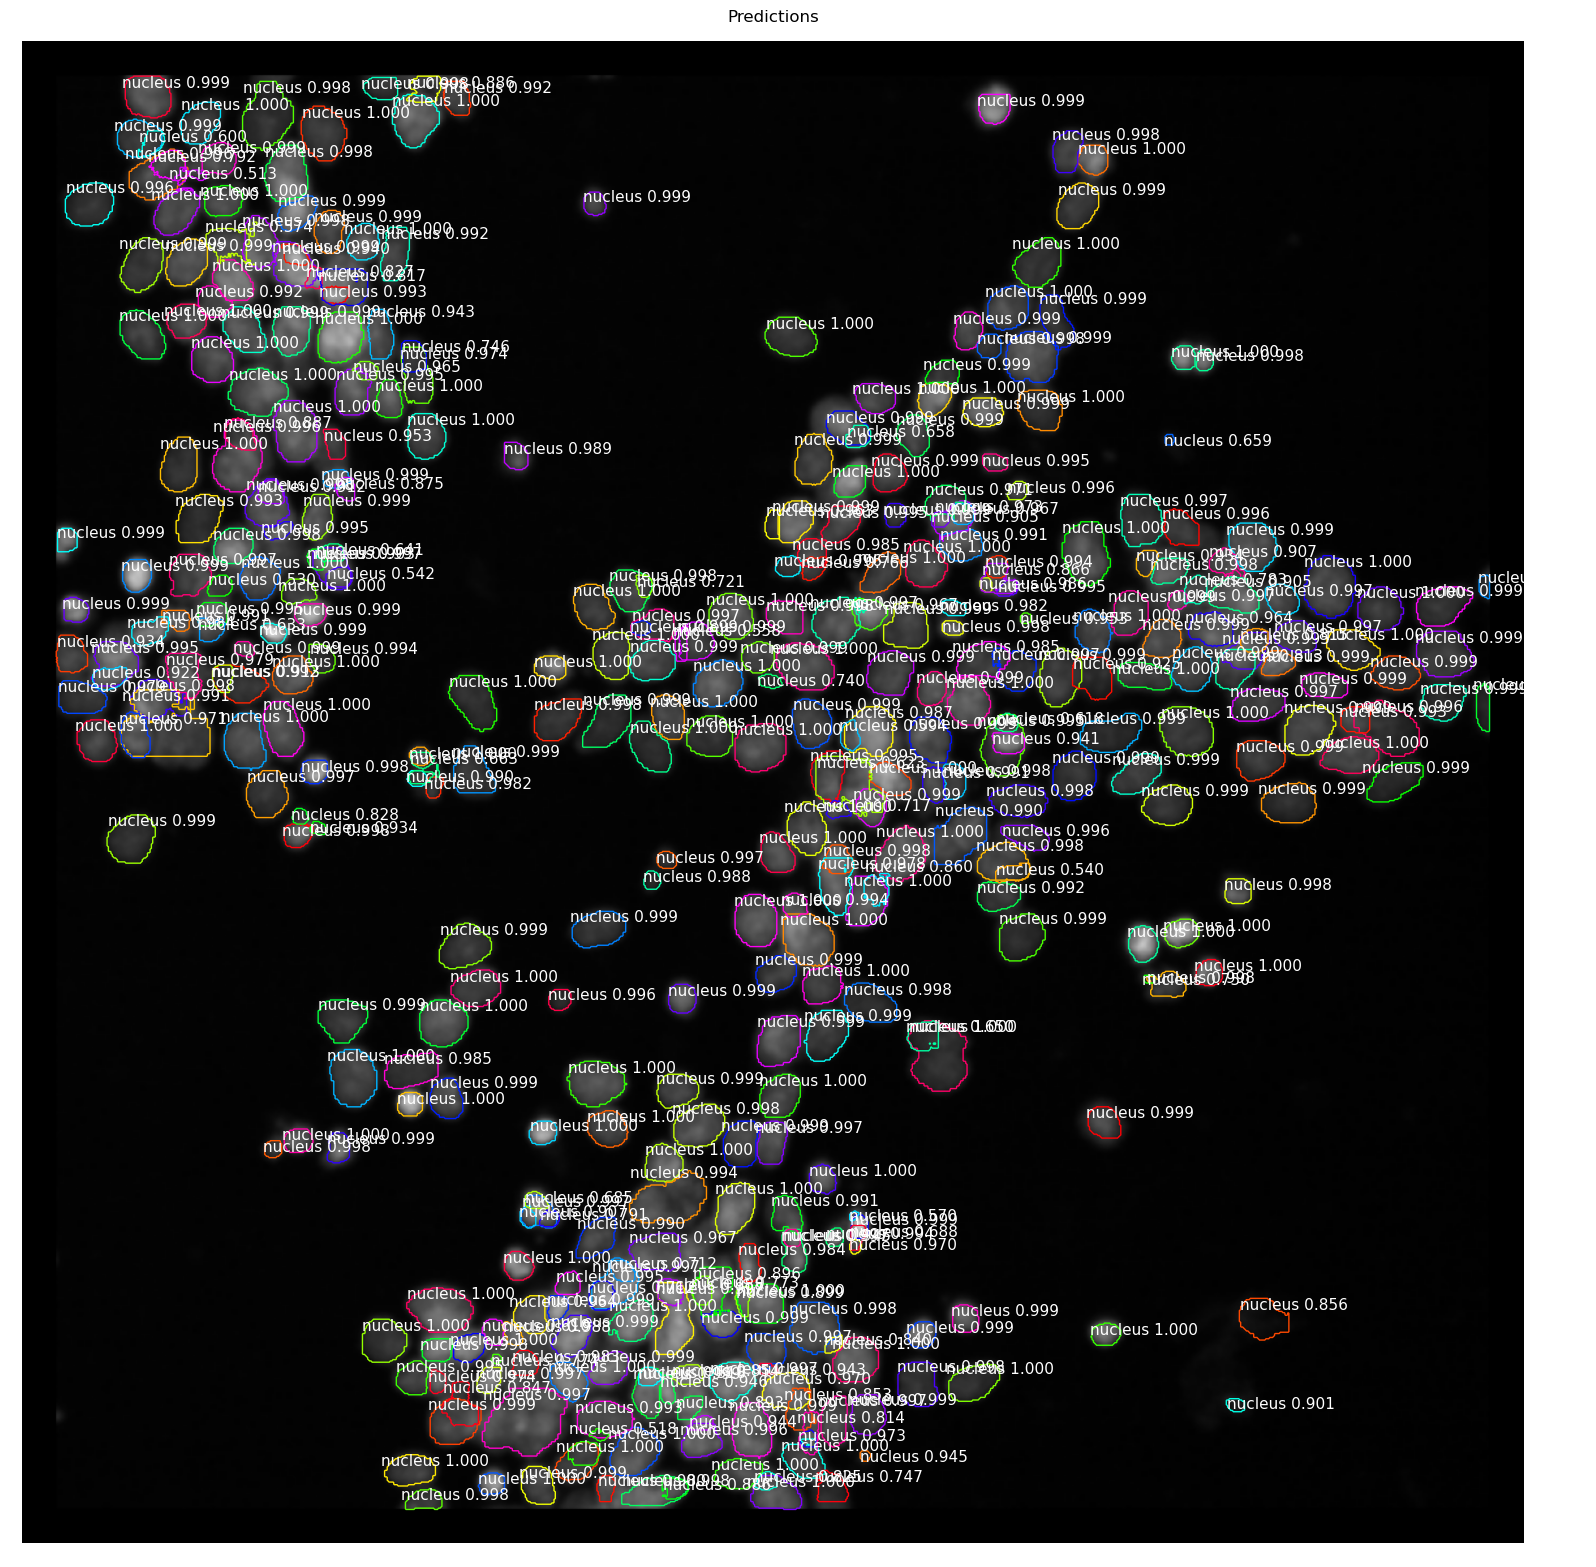

In [8]:
print(im_paths_nb[0])
## we quarter the image, because there is an upper limit on the number of instances that we can detect per image
seg, masks = read_image_show_segmentation_with_score(im_paths_nb[1], config, quarter=True)

In [9]:
## here, we segment as we do in our cellprofiler module
raw_image = io.imread(im_paths_nb[1])
input_image = segmentation_functions.preprocess_image(raw_image)
seg_im = segmentation_functions.segment_single_image(input_image, model, quarter_overlap=10, resolve_overlaps=True)

Segmentation test print - non molded detection
Input image shape is (1080, 1080, 3)


In [10]:
print(np.unique(seg_im))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

C:\Users\ben.haladik\AppData\Local\Temp\ipykernel_34212\3436432175.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


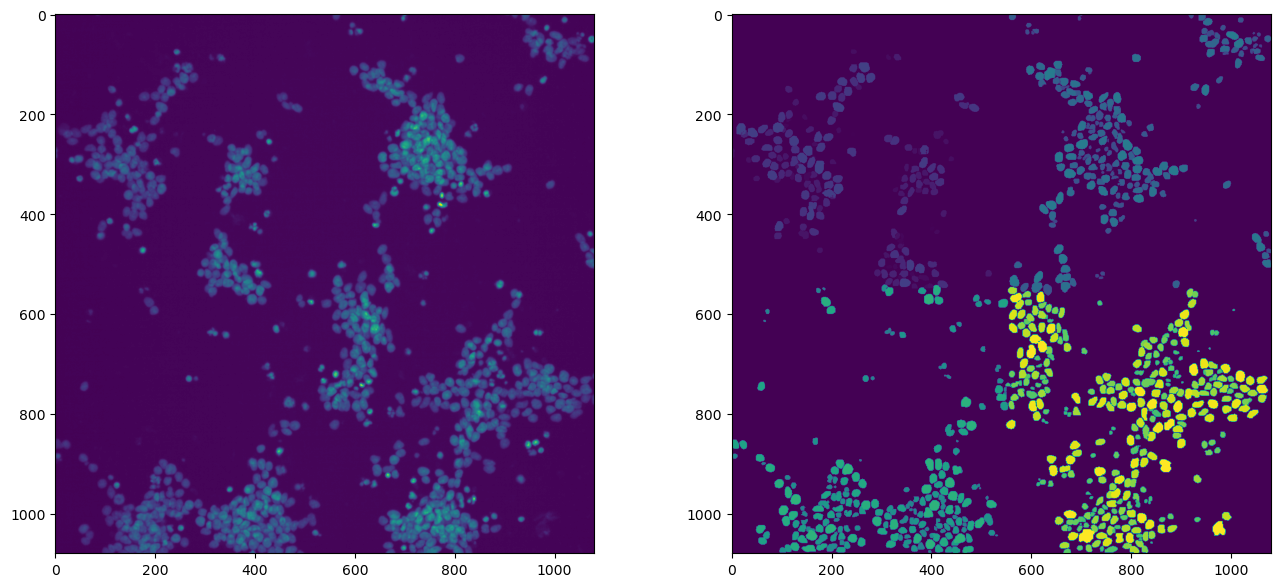

In [11]:
fig, ax = plt.subplots(figsize=(16,7), ncols=2)
ax[0].imshow(raw_image)
ax[1].imshow(seg_im.astype(np.uint32))
fig.show()